# **Initialization**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import copy

!pip install optuna
import optuna

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten, Input, Layer, InputSpec, Lambda, Concatenate
from keras.initializers import glorot_uniform, ones, zeros
import keras.backend as K

!git clone https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-.git
import os
os.chdir('/content/Survival-Analysis-Deep-Learning-AML-/Data')

# **Data**

In [ ]:
patient_data = pd.read_excel("Table 10.xlsx").sort_index()
gene_expression_df = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
models = []

In [ ]:
gene_expression = tf.convert_to_tensor(gene_expression_df.astype("float32"))

# **Auxiliary functions**

In [ ]:
def plot(history,size):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(history.history['loss'])+1)
    plt.plot(x_axis, history.history['loss'], label='training')
    plt.plot(x_axis, history.history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # plt.subplot(1,2,2)
    # x_axis = np.arange(1, len(history.history['accuracy'])+1)
    # plt.plot(x_axis, history.history['accuracy'], label='training')
    # plt.plot(x_axis, history.history['val_accuracy'], label='validation')
    # plt.title('Training and validation accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend(loc='lower right')

    return fig

In [ ]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        print(" This is the best trial so far")
        #study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
        # study.set_user_attr(key="training_loss", value=trial.user_attrs["training_loss"])
        # study.set_user_attr(key="validation_loss", value=trial.user_attrs["validation_loss"])

In [ ]:
def classification(index, L):
    classifiction = list(np.zeros(L-1))
    classifiction.insert(index, 1)
    return classifiction

In [ ]:
def Heatmap_Clustering(soft_labels, patient_data, var_of_interest):

    num_clusters        = len(soft_labels[0][:])
    clusters            = ["c{}".format(i+1) for i in range(num_clusters)]
    soft_labels         = pd.DataFrame(soft_labels.numpy(), columns = clusters)
    patient_data_cat    = pd.DataFrame(patient_data[var_of_interest])
    soft_labels_cat     = patient_data_cat.join(soft_labels)
    patient_labels      = np.unique(patient_data_cat)
    num_categories      = len(patient_labels)

    heatmap_data = pd.DataFrame(index = patient_labels, columns = clusters, dtype= "float32")
    # heatmap_data    = np.empty(shape=(num_categories, num_clusters))

    for i, entity in enumerate(patient_labels):

        cluster                     = soft_labels_cat[soft_labels_cat[var_of_interest]==entity]
        del cluster[var_of_interest]

        num_patients                = len(cluster)
        average_label_assignment    = np.sum(cluster, axis = 0) / num_patients
        heatmap_data.loc[entity]        = average_label_assignment
    
    heatmap_figure      = plt.figure(figsize=(15,12))
    heatmap             = sns.heatmap(heatmap_data, annot= True, fmt= ".4f")

In [ ]:
def tSNE_plot(coords, var_of_interest):
    
    tsne = TSNE(2, perplexity = 20, verbose=1, random_state = 69)
    tsne_coordinates = tsne.fit_transform(coords)

    patientdat = patient_data[var_of_interest]
    labels = patientdat.astype('category').cat.codes.to_list()
    num_colors = len(np.unique(labels))
    colors = plt.get_cmap('rainbow', num_colors)

    fig_tsne = plt.figure(figsize= (10,10))
    plt.scatter(tsne_coordinates[:,0], tsne_coordinates[:,1], c= colors(labels))
    plt.legend()

# **VAE**

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    latent_dim = K.shape(z_mean)
    epsilon = K.random_normal(shape=(latent_dim[0], latent_dim[1]),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [ ]:
def VAE(input_dim, structure):

    hidden_layers_e = structure["hidden layers"]
    hidden_layers_d = hidden_layers_e[::-1]
    latent_dim      = structure["latent layer size"]
    activation      = structure["activation"]
    drop            = structure["dropout rate"]

    input_e         = Input(shape   = (input_dim,), 
                            name    = "Input")
    input_d         = Input(shape   = (latent_dim,), 
                            name    = "Input")
    
    coder_length    = len(hidden_layers_e)
    names_e         = ["Encoding_layer_"]*coder_length
    names_d         = ["Decoding_layer_"]*coder_length

    hidden_layer_e  = Dense(hidden_layers_e[0],
                            kernel_initializer  = glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_e[0], 1))(input_e)
    hidden_layer_d  = Dense(hidden_layers_d[0],
                            kernel_initializer  = glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_d[0], 1))(input_d)

    hidden_layers_e.pop(0)
    hidden_layers_d.pop(0)

    for i in range(len(hidden_layers_e)):
        hidden_layer_e    = Dense(hidden_layers_e[i],
                                kernel_initializer  = glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_e[i], i+2))(hidden_layer_e)
        hidden_layer_d    = Dense(hidden_layers_d[i],
                                kernel_initializer  = glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_d[i], i+2))(hidden_layer_d)
    
    mean    = Dense(latent_dim,
                    kernel_initializer  = glorot_uniform(),
                    name                = "z_mean")(hidden_layer_e)
    sigma   = Dense(latent_dim,
                    kernel_initializer  = glorot_uniform(),
                    name                = "z_sigma")(hidden_layer_e)
    z       = Lambda(sampling, name = "Sampling")([mean, sigma])

    output  = Dense(input_dim,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")(hidden_layer_d)          

    encoder     = Model(inputs  = input_e, 
                        outputs = [mean, sigma, z], 
                        name    = "VAE-encoder")
    decoder     = Model(inputs  = input_d, 
                        outputs = output, 
                        name    = "VAE-decoder")
    
    inputs      = Input(shape   = (input_dim,), 
                        name    = "Input")
    outputs     = decoder(encoder(input_e)[-1])
    autoencoder = keras.Model(inputs    = input_e, 
                      outputs   = outputs, 
                      name      = "VAE")

    return encoder, decoder, autoencoder

In [ ]:
input_dim = 381
structure = {"hidden layers"    :   list(np.random.randint(1,5,5)),
             "latent layer size":   3,
             "activation"       :   "relu",
             "dropout rate"     :   0.2}
encoder, decoder, autoencoder = VAE(input_dim, structure)

encoder.build(input_shape=(None,input_dim))
encoder.summary()
decoder.build(input_shape=(None,input_dim))
decoder.summary()
autoencoder.build(input_shape=(None,input_dim))
autoencoder.summary()

# L = structure["hidden layers"][0]
# print(L)

# autoencoder.get_layer(name= "VAE-encoder").get_layer(name= "Encoding_layer_1").set_weights(np.ones(L-1))


Model: "VAE-encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 381)]        0                                            
__________________________________________________________________________________________________
Encoding_layer_1 (Dense)        (None, 1)            382         Input[0][0]                      
__________________________________________________________________________________________________
Encoding_layer_2 (Dense)        (None, 3)            6           Encoding_layer_1[0][0]           
__________________________________________________________________________________________________
Encoding_layer_3 (Dense)        (None, 2)            8           Encoding_layer_2[0][0]           
________________________________________________________________________________________

In [ ]:
def training_VAE(model, epochs, data = gene_expression):

    @tf.function(experimental_relax_shapes=True)
    def trainstep(model, x_train, optimizer, mse):

        with tf.GradientTape() as tape:

            autoencoding        = model(x_train, training = True)
            ae_loss             = mse(x_train, autoencoding)

            encoder             = Model(inputs=autoencoder.input,
                                        outputs=autoencoder.get_layer("VAE-encoder").output)
            distribution        = encoder(gene_expression)[:2]
            mean                = distribution[0]
            sigma               = distribution[1]
            num_patients, dim   = mean.shape

            p                   = K.random_normal(shape     =(num_patients, dim),
                                                  mean      = 0., 
                                                  stddev    = 0.1)
            q                   = K.random_normal(shape     =(num_patients, dim),
                                                  mean      = 0., 
                                                  stddev    = 0.1)
            
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return loss

    @tf.function(experimental_relax_shapes=True)
    def teststep(model, x_test, optimizer, mse):



        return loss

    input_dim       = data.shape[1]

    scaler  = MinMaxScaler()
    data    = pd.DataFrame(scaler.fit_transform(data))

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = data.iloc[ind_shuffle][:train_size]
    x_test      = data.iloc[ind_shuffle][train_size:]

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    optimizer = keras.optimizers.SGD(learning_rate= 0.01)
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = []
    loss_test   = []

    for i in range(epochs):

        train_loss  = trainstep(model, x_train, optimizer)
        loss_train.append(train_loss)
        test_loss   = teststep(model, x_test, optimizer)
        loss_test.append(test_loss)

    return model, loss_train, loss_test

# **Auto-encoding**

In [ ]:
def Auto_encoder(input_size, structure):
    
    hidden_layers   = structure['hidden layers']
    embedding_size  = structure['embedding layer']
    activation      = structure['activation']
    drop            = structure["dropout rate"]

    structure       = hidden_layers + [embedding_size] + hidden_layers[::-1]
    
    coder_length    = len(hidden_layers)

    model           = Sequential(name = "Auto-encoder")

    model.add(Input(shape   = (input_size,), 
                    name    = "Input"))
    
    names           = ["Encoding_layer-"]*coder_length + ["Embedding_layer"] + ["Decoding_layer-"]*coder_length
    numbers         = np.concatenate((np.array(range(coder_length)) + 1, np.array(range(coder_length))+1)).tolist()

    numbers.insert(coder_length, "")

    for i,j in enumerate(structure):
        model.add(Dense(j,
                        kernel_initializer  = glorot_uniform(),
                        activation          = activation,
                        name                = "{}{}".format(names[i],numbers[i]))
        )
        model.add(Dropout(drop,
                          name = "Dropout-{}".format(i+1)))
    
    model.add(Dense(input_size,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")
    )

    return model


In [ ]:
def par_tuner(trial):

    global gene_expression, models

    #gene_expression = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
    # gene_expression = gene_expression.astype("float32")
    input_dim       = gene_expression.shape[1]

    scaler = MinMaxScaler()
    gene_expression = pd.DataFrame(scaler.fit_transform(gene_expression))

    num_patients    = gene_expression.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = gene_expression.iloc[ind_shuffle][:train_size]
    x_test      = gene_expression.iloc[ind_shuffle][train_size:]

    gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    embedding_layer = trial.suggest_int("embedding layer size", 10, 50)
    activation      = trial.suggest_categorical("activation", ["relu", "selu"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-4, 1)
    momentum        = trial.suggest_float("momentum", 0, 0.999)

    tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum)

    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 2000)
        hidden_layers.append(hlayer)

    structure = {"hidden layers"    :   hidden_layers,
                 "embedding layer"  :   embedding_layer,
                 "activation"       :   activation,
                 "dropout rate"     :   dropout_rate}

    model = Auto_encoder(input_dim, structure)

    model.compile(loss      = "mse", 
                  optimizer = optimizer,
                  metrics   = ["accuracy"])

    history = model.fit(x_train, 
                        x_train,
                        epochs          = 100,
                        validation_data = (x_test,x_test),
                        verbose = False)
    
    global models
    models.append(model)

    loss, accuracy    = model.evaluate(x_test,x_test, verbose = False)

    # if trial.number == 0:
    #     trial.set_user_attr("Best model", model)
    # elif loss < trial.user_attrs[1]:
    #     trial.set_user_attr("Best model", model)
    # trial.set_user_attr(key="best_booster", value=model)
    # print(trial.user_attrs)
    # plot(history,10)

    return loss

In [ ]:
def find_autoencoder(n,d):

    global models, gene_expression
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning auto-encoder")
    study.optimize(par_tuner, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    n_encoding_layers   = trial.params["N_layers"] 
    encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    encoder             = Sequential(encoding_layers) 

    
    kmeans = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder.predict(gene_expression))
    encoder.add(ClusteringLayer(d, name = "cluster"))

    encoder.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    encoder.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return trial, autoencoder, encoder

# **Clustering**

## Clustering layer

In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def add_cluslayer(model, data, d):

    input_size  = data.shape[1]
    encoder_cluster   = tf.keras.models.clone_model(model)
    encoder_cluster.build(input_shape = (None, input_size))
    encoder_cluster.set_weights(model.get_weights())

    kmeans      = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder_cluster.predict(data))
    encoder_cluster.add(ClusteringLayer(d, name = "cluster"))

    encoder_cluster.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    #encoder_cluster.build(input_shape= (None,input_size))

    return encoder_cluster

## Training

In [ ]:
def training(model, epochs, data = gene_expression):

    @tf.function(experimental_relax_shapes=True)
    def trainstep(model, x_train, optimizer):

        with tf.GradientTape() as tape:

            q       = model(x_train, training= True)
            p       = K.square(q) / K.sum(q, axis=0)
            p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
            loss    = K.sum(p*K.log(p/q))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return loss

    @tf.function(experimental_relax_shapes=True)
    def teststep(model, x_test, optimizer):

        q       = model(x_test, training= False)
        p       = K.square(q) / K.sum(q, axis=0)
        p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
        loss    = K.sum(p*K.log(p/q))

        return loss

    input_dim       = data.shape[1]

    scaler  = MinMaxScaler()
    data    = pd.DataFrame(scaler.fit_transform(data))

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = data.iloc[ind_shuffle][:train_size]
    x_test      = data.iloc[ind_shuffle][train_size:]

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    optimizer = keras.optimizers.SGD(learning_rate= 0.01)
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = []
    loss_test   = []

    for i in range(epochs):

        train_loss  = trainstep(model, x_train, optimizer)
        loss_train.append(train_loss)
        test_loss   = teststep(model, x_test, optimizer)
        loss_test.append(test_loss)

    return model, loss_train, loss_test


In [ ]:
var_of_interest     = "Transcriptional_Identity"
trial, autoencoder, encoder = find_autoencoder(1,10)
coords  = encoder(gene_expression, training = False)
# tSNE_plot(coords, var_of_interest)

[I 2021-10-27 05:55:12,283] A new study created in memory with name: Tuning auto-encoder
[I 2021-10-27 05:55:34,764] Trial 0 finished with value: 0.02907884307205677 and parameters: {'N_layers': 3, 'embedding layer size': 17, 'activation': 'relu', 'optimizer': 'adam', 'dropout rate': 0.04763270123762782, 'learning rate': 0.9635282597544916, 'momentum': 0.8805463227511694, 'hlay 1': 339, 'hlay 2': 1910, 'hlay 3': 295}. Best is trial 0 with value: 0.02907884307205677.


 This is the best trial so far
Number of finished trials: 1
Best trial:
  Value: 0.02907884307205677
  Params: 
    N_layers: 3
    embedding layer size: 17
    activation: relu
    optimizer: adam
    dropout rate: 0.04763270123762782
    learning rate: 0.9635282597544916
    momentum: 0.8805463227511694
    hlay 1: 339
    hlay 2: 1910
    hlay 3: 295


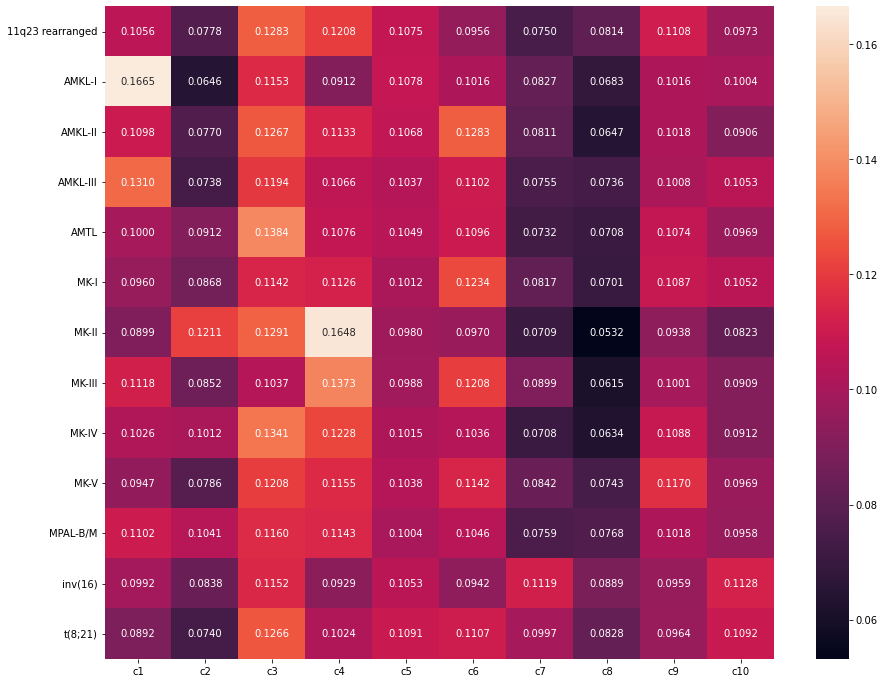

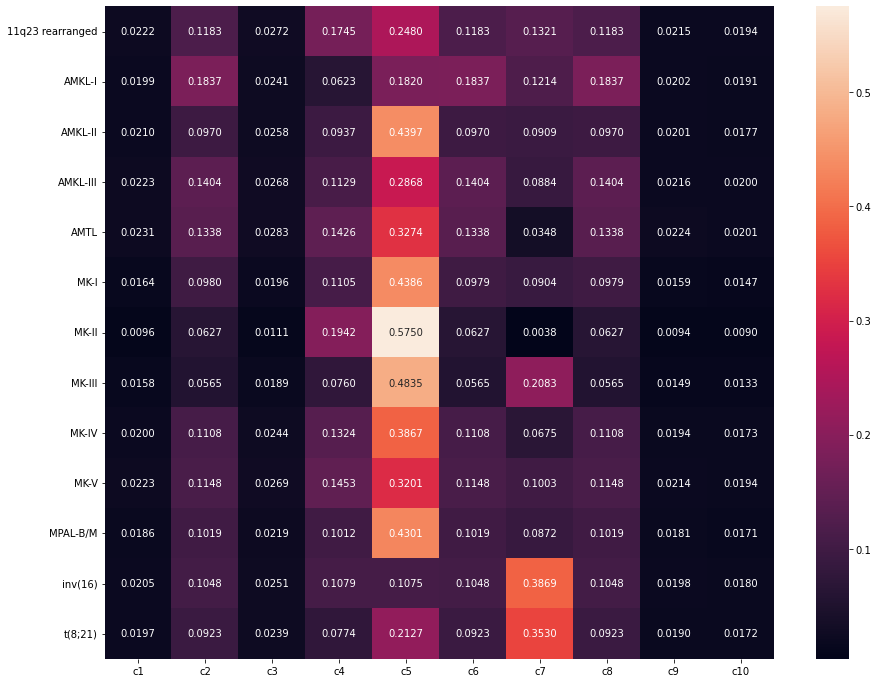

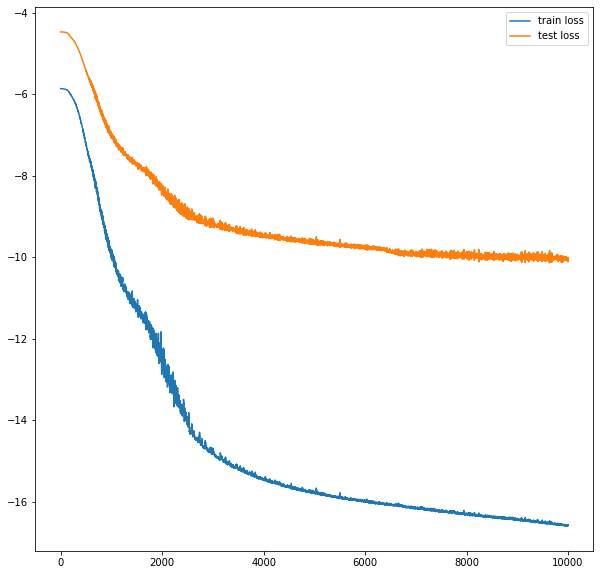

In [ ]:
@tf.function(experimental_relax_shapes=True)
def trainstep(model, x_train, optimizer):

    with tf.GradientTape() as tape:

        q       = model(x_train, training= True)
        p       = K.square(q) / K.sum(q, axis=0)
        p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
        loss    = K.sum(p*K.log(p/q))

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss

@tf.function(experimental_relax_shapes=True)
def teststep(model, x_test, optimizer):

    q       = model(x_test, training= False)
    p       = K.square(q) / K.sum(q, axis=0)
    p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
    loss    = K.sum(p*K.log(p/q))

    return loss

data        = gene_expression

# encoder_cluster     = add_cluslayer(encoder, data, 13)

var_of_interest = "Transcriptional_Identity"
results         = encoder(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

input_size  = data.shape[1]
encoder_2   = tf.keras.models.clone_model(encoder)
encoder_2.build(input_shape = (None, input_size))
# encoder_2.set_weights(encoder_cluster.get_weights())
# encoder_2.summary()

encoder_2, train_loss, test_loss    = training(encoder_2, 10000)

results         = encoder_2(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

fig = plt.figure(figsize=(10,10))
plt.plot(train_loss, label = 'train loss')
plt.plot(test_loss, label = 'test loss')
plt.legend()

# **Visualizing clusters**

In [ ]:
encoder_3   = tf.keras.models.clone_model(encoder_2)
encoder_3.build(input_shape = (None, input_size))
encoder_3.set_weights(encoder_2.get_weights())